In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [8]:
path = '../abalone/abalone.data'
df = pd.read_csv(path, names=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


rings
1    1891
2    1186
0     839
3     261
Name: count, dtype: int64


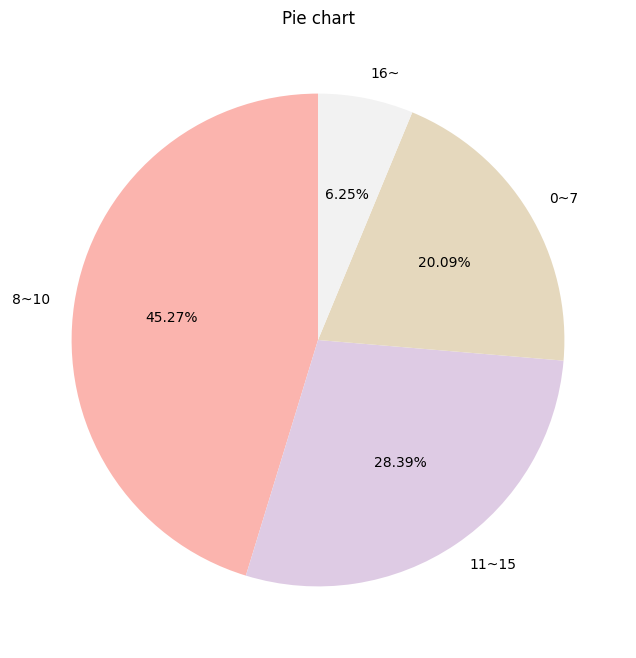

In [9]:
# Use the recommend multiclass classifier
def multi_class(x):
    if x <= 7:
        return 0
    elif x <= 10:
        return 1
    elif x <= 15:
        return 2
    else:
        return 3
class_dict = {0: '0~7', 1: '8~10', 2: '11~15', 3: '16~'}
# Use different number to map the value of ring-age
y = df.iloc[:, -1].map(multi_class)
X = df.iloc[:, :-1]
# 对性别进行映射
X['sex'] = X['sex'].map({'M': 0, 'F': 1, 'I': 3})
# 这里用的是老师的方法分类,并不均匀
print(y.value_counts())
cmap = cm.get_cmap('Pastel1')
abalone_colors = [cmap(i) for i in np.linspace(0, 1, len(y.value_counts()))]
plt.figure(figsize=(8, 8))
plt.pie(y.value_counts(), autopct='%.2f%%',
        startangle=90, labels=[class_dict[s] for s in y.value_counts().index], colors=abalone_colors)
plt.title('Pie chart')
plt.show()

In [41]:
# 还可以使用分桶的操作，来保证分布均匀的问题
#bins_1 可以让每个去区间的分布数量尽量平均
bins_1 = pd.qcut(df.iloc[:, -1], q=4)
print(bins_1.value_counts())
# bins_2 让数值区间相同
bins_2 = pd.cut(df.iloc[:, -1], bins=4)
print(bins_2.value_counts())

rings
(0.999, 8.0]    1407
(9.0, 11.0]     1121
(11.0, 29.0]     960
(8.0, 9.0]       689
Name: count, dtype: int64
rings
(8.0, 15.0]     2509
(0.972, 8.0]    1407
(15.0, 22.0]     245
(22.0, 29.0]      16
Name: count, dtype: int64


In [42]:
# 由于数据是处理过的，不需要再去做额外的特征工程
# 由于是多分类，我们可以使用One-to-one或者One-to-rest的方式
# 同时引入K折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def simple_nn_train(model, X=X, y=y, iter=30):
    ovo = []
    ovr = []
    for stra in ['ovo', 'ovr']:
        f1_socre_list = []
        roc_auc_score_list = []
        for i in range(1, iter + 1):
            f1_res = []
            roc_auc_res = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)
                f1 = f1_score(y_test, y_pred, average='micro')
                roc_auc = roc_auc_score(y_test, y_prob, multi_class=stra)
                f1_res.append(f1)
                roc_auc_res.append(roc_auc)
            f1_res_mean = np.mean(f1_res)
            roc_auc_res_mean = np.mean(roc_auc_res)
            if i % (iter / 10) == 0:
                print(
                    f'Iteration {i}/ {iter}: Using Stragety {stra} f1_score={f1_res_mean:.3f}; roc_auc={roc_auc_res_mean:.3f}')
            f1_socre_list.append(f1_res_mean)
            roc_auc_score_list.append(roc_auc_res_mean)
        print(
            f'Final Summary: Iterations {iter}, Stragety {stra}, f1_score={f1_socre_list[-1]:.3f}, roc_auc={roc_auc_score_list[-1]:.3f}')
        if stra == 'ovo':
            ovo.append(f1_socre_list)
            ovo.append(roc_auc_score_list)
        else:
            ovr.append(f1_socre_list)
            ovr.append(roc_auc_score_list)
    return ovo, ovr

In [50]:
iters = 100
print('Default Configuration')
default_ovo, default_ovr = simple_nn_train(MLPClassifier(warm_start=True, early_stopping=True), iter=iters)
print('Using solver=adam')
adam_ovo, adam_ovr = simple_nn_train(MLPClassifier(solver='adam', warm_start=True, early_stopping=True), iter=iters)

Default Configuration
Iteration 10/ 100: Using Stragety ovo f1_score=0.625; roc_auc=0.831
Iteration 20/ 100: Using Stragety ovo f1_score=0.638; roc_auc=0.849
Iteration 30/ 100: Using Stragety ovo f1_score=0.647; roc_auc=0.853
Iteration 40/ 100: Using Stragety ovo f1_score=0.641; roc_auc=0.855
Iteration 50/ 100: Using Stragety ovo f1_score=0.643; roc_auc=0.856
Iteration 60/ 100: Using Stragety ovo f1_score=0.646; roc_auc=0.857
Iteration 70/ 100: Using Stragety ovo f1_score=0.650; roc_auc=0.859
Iteration 80/ 100: Using Stragety ovo f1_score=0.648; roc_auc=0.861
Iteration 90/ 100: Using Stragety ovo f1_score=0.650; roc_auc=0.862
Iteration 100/ 100: Using Stragety ovo f1_score=0.651; roc_auc=0.862
Final Summary: Iterations 100, Stragety ovo, f1_score=0.651, roc_auc=0.862
Iteration 10/ 100: Using Stragety ovr f1_score=0.654; roc_auc=0.867
Iteration 20/ 100: Using Stragety ovr f1_score=0.655; roc_auc=0.867
Iteration 30/ 100: Using Stragety ovr f1_score=0.655; roc_auc=0.868
Iteration 40/ 100:

In [7]:
# 绘制收敛速度的曲线
# 封装绘制图片的函数
def plot_scores(tag='Default', iters=iters, data=None, score='f1_score'):
    if score == 'f1_score': d = 0
    else: d = 1
    plt.plot(range(1, iters + 1), data[d], label=tag)

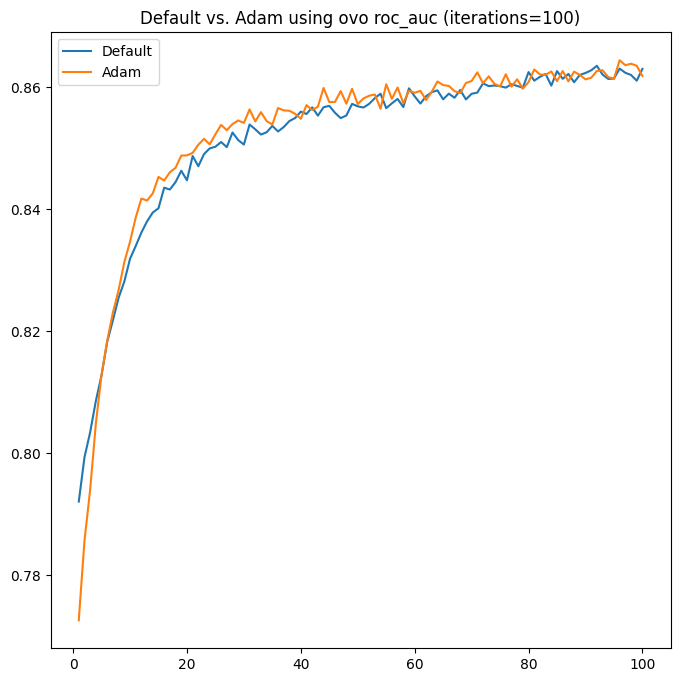

In [8]:
plt.figure(figsize=(8, 8))
plot_scores(tag='Default', data=default_ovo, score='roc_auc')
plot_scores(tag='Adam', data=adam_ovo, score='roc_auc')
plt.title(f'Default vs. Adam using ovo roc_auc (iterations={iters})')
plt.legend()
plt.show()

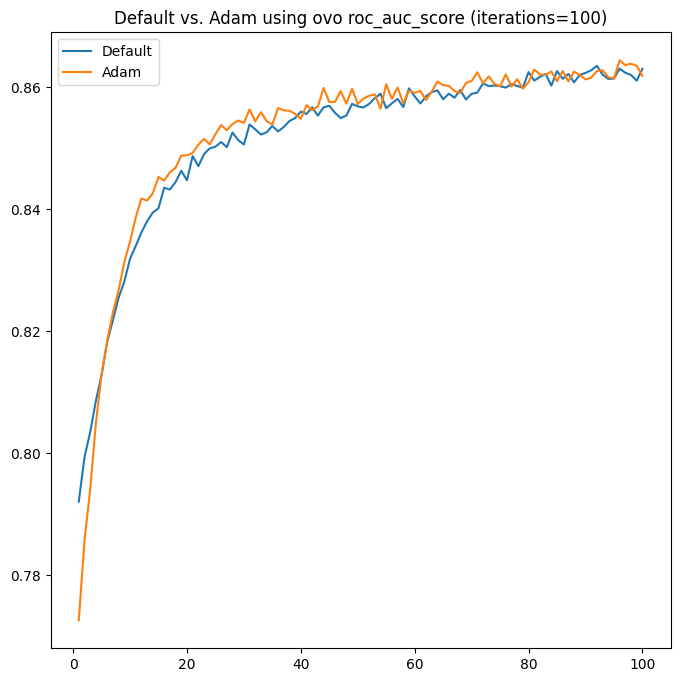

In [ ]:
plt.figure(figsize=(8, 8))
plot_scores(tag='Default', data=default_ovo, score='f1_score')
plot_scores(tag='Adam', data=adam_ovo, score='f1_score')
plt.title(f'Default vs. Adam using ovo f1_score (iterations={iters})')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.legend()
plt.show()
# 由于ovr表现不稳定没法体现Adam的优势，所以不画图

In [6]:
# 由于后面需要使用到dropout的技巧，这里就需要调用pytorch里面的神经网络了
# 先构建一个使用Adam作为优化器并且添加了L2的神经网络
class SGD(nn.Module):
    def __init__(self, n_class=4):
        super(SGD, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, n_class)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [7]:
# 处理数据
def data2loader(X, y, batch_size=64, val_pct=0.3):
    X_tensor, y_tensor = torch.tensor(X.values), torch.tensor(y.values)


    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int((1 - val_pct) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader
train_loader, val_loader = data2loader(X, y)

In [8]:

epoches = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

def train_eval(model, device, train_loader, val_loader, epoches, lr=0.001, weight_decay=0, verbose=True):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    finally_f1 = 0
    finally_roc_auc = 0
    for epoch in range(epoches):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            labels_cpu = labels.cpu().numpy()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Loss:', loss.item())
        model.eval()
        correct = 0
        total = 0
        val_pred = []
        val_labels = []
        val_prob = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_pred.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_prob.extend(outputs.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Accuracy', round(correct / total, 5))
        finally_f1 = f1_score(val_labels, val_pred, average='micro')
        finally_roc_auc = roc_auc_score(val_labels, val_prob, multi_class='ovo', average='macro')
    print(f'Final Summary: f1_score {finally_f1:.5f}; roc_auc_score {finally_roc_auc:.5f}')

In [151]:
train_eval(SGD(), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.3163193464279175
Epoch: 0 Accuracy 0.45136
Epoch: 10 Loss: 1.1741442680358887
Epoch: 10 Accuracy 0.60207
Epoch: 20 Loss: 1.19151771068573
Epoch: 20 Accuracy 0.61802
Epoch: 30 Loss: 1.1669590473175049
Epoch: 30 Accuracy 0.62201
Epoch: 40 Loss: 1.1581363677978516
Epoch: 40 Accuracy 0.63238
Epoch: 50 Loss: 1.1358473300933838
Epoch: 50 Accuracy 0.63158
Epoch: 60 Loss: 1.270272970199585
Epoch: 60 Accuracy 0.63876
Epoch: 70 Loss: 1.093206524848938
Epoch: 70 Accuracy 0.64514
Epoch: 80 Loss: 1.0228747129440308
Epoch: 80 Accuracy 0.64195
Epoch: 90 Loss: 1.1027799844741821
Epoch: 90 Accuracy 0.63477
Epoch: 100 Loss: 1.0993379354476929
Epoch: 100 Accuracy 0.64434
Epoch: 110 Loss: 1.0063854455947876
Epoch: 110 Accuracy 0.63397
Epoch: 120 Loss: 1.0750538110733032
Epoch: 120 Accuracy 0.64593
Epoch: 130 Loss: 1.1407753229141235
Epoch: 130 Accuracy 0.64833
Epoch: 140 Loss: 1.0482591390609741
Epoch: 140 Accuracy 0.64354
Epoch: 150 Loss: 1.0615649223327637
Epoch: 150 Accuracy 0.64195
Ep

In [9]:
# 引入Dropout
class SGDDropout(nn.Module):
    def __init__(self, dropout=0.5, n_class=4):
        super(SGDDropout, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.drop = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(64, n_class)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [15]:
train_eval(SGDDropout(), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.2882885932922363
Epoch: 0 Accuracy: 0.4513556618819777
Epoch: 10 Loss: 1.2466328144073486
Epoch: 10 Accuracy: 0.5901116427432217
Epoch: 20 Loss: 1.1485671997070312
Epoch: 20 Accuracy: 0.594896331738437
Epoch: 30 Loss: 1.0487722158432007
Epoch: 30 Accuracy: 0.6052631578947368
Epoch: 40 Loss: 1.2182685136795044
Epoch: 40 Accuracy: 0.6180223285486444
Epoch: 50 Loss: 1.0152571201324463
Epoch: 50 Accuracy: 0.6140350877192983
Epoch: 60 Loss: 1.0292266607284546
Epoch: 60 Accuracy: 0.6180223285486444
Epoch: 70 Loss: 1.0962085723876953
Epoch: 70 Accuracy: 0.6220095693779905
Epoch: 80 Loss: 1.154160976409912
Epoch: 80 Accuracy: 0.6220095693779905
Epoch: 90 Loss: 1.0572060346603394
Epoch: 90 Accuracy: 0.6244019138755981
Final Summary: loss 1.10237; Accuracy 0.62041


In [10]:
# 加入l2正则化
train_eval(SGD(), device=device, train_loader=train_loader, val_loader=val_loader, epoches=100, weight_decay=0.001)

Epoch: 0 Loss: 1.322778344154358
Epoch: 0 Accuracy 0.45056
Epoch: 10 Loss: 1.139749526977539
Epoch: 10 Accuracy 0.57416
Epoch: 20 Loss: 1.1649028062820435
Epoch: 20 Accuracy 0.58214
Epoch: 30 Loss: 1.1758718490600586
Epoch: 30 Accuracy 0.59011
Epoch: 40 Loss: 1.1045048236846924
Epoch: 40 Accuracy 0.5925
Epoch: 50 Loss: 1.1304646730422974
Epoch: 50 Accuracy 0.60048
Epoch: 60 Loss: 1.1481162309646606
Epoch: 60 Accuracy 0.60686
Epoch: 70 Loss: 1.0979883670806885
Epoch: 70 Accuracy 0.61404
Epoch: 80 Loss: 1.1245214939117432
Epoch: 80 Accuracy 0.62041
Epoch: 90 Loss: 1.1483802795410156
Epoch: 90 Accuracy 0.61483
Final Summary: f1_score 0.61085; roc_auc_score 0.66935


In [100]:
# 尝试不同的combination来测试
dropouts = [0.4, 0.5, 0.6, 0.7]
weight_decays = [1e-2, 1e-3, 5e-3, 5e-4]


In [110]:
for d_rate in dropouts:
    print(f'Dropout: {d_rate}')
    train_eval(SGDDropout(d_rate), device, train_loader, val_loader=val_loader, epoches=epoches, verbose=False)
for w_decay in weight_decays:
    print(f'Weight decay: {w_decay}')
    train_eval(SGD(), device, train_loader, val_loader=val_loader, epoches=epoches, weight_decay=w_decay, verbose=False)

Dropout: 0.4
Final Summary: loss 1.18047; Accuracy 0.65710
Dropout: 0.5
Final Summary: loss 1.12273; Accuracy 0.65550
Dropout: 0.6
Final Summary: loss 1.15580; Accuracy 0.63636
Dropout: 0.7
Final Summary: loss 1.03931; Accuracy 0.65470
Weight decay: 0.01
Final Summary: loss 1.18705; Accuracy 0.60526
Weight decay: 0.001
Final Summary: loss 1.02910; Accuracy 0.66108
Weight decay: 0.005
Final Summary: loss 1.14694; Accuracy 0.61722
Weight decay: 0.0005
Final Summary: loss 1.08092; Accuracy 0.64753


In [2]:
# 引入新数据
from ucimlrepo import fetch_ucirepo

# fetch dataset
contraceptive_method_choice = fetch_ucirepo(id=30)

# data (as pandas dataframes)
X_B = contraceptive_method_choice.data.features
y_B = contraceptive_method_choice.data.targets

# metadata
print(contraceptive_method_choice.metadata)

# variable information
print(contraceptive_method_choice.variables)

{'uci_id': 30, 'name': 'Contraceptive Method Choice', 'repository_url': 'https://archive.ics.uci.edu/dataset/30/contraceptive+method+choice', 'data_url': 'https://archive.ics.uci.edu/static/public/30/data.csv', 'abstract': 'Dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1473, 'num_features': 9, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Education Level', 'Other', 'Occupation'], 'target_col': ['contraceptive_method'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C59W2D', 'creators': ['Tjen-Sien Lim'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either

In [ ]:
# 先看看缺失集的问题
print('The distribution nan value in different features')
X_B.isna().sum()

wife_age                    0
wife_edu                    0
husband_edu                 0
num_children                0
wife_religion               0
wife_working                0
husband_occupation          0
standard_of_living_index    0
media_exposure              0
dtype: int64

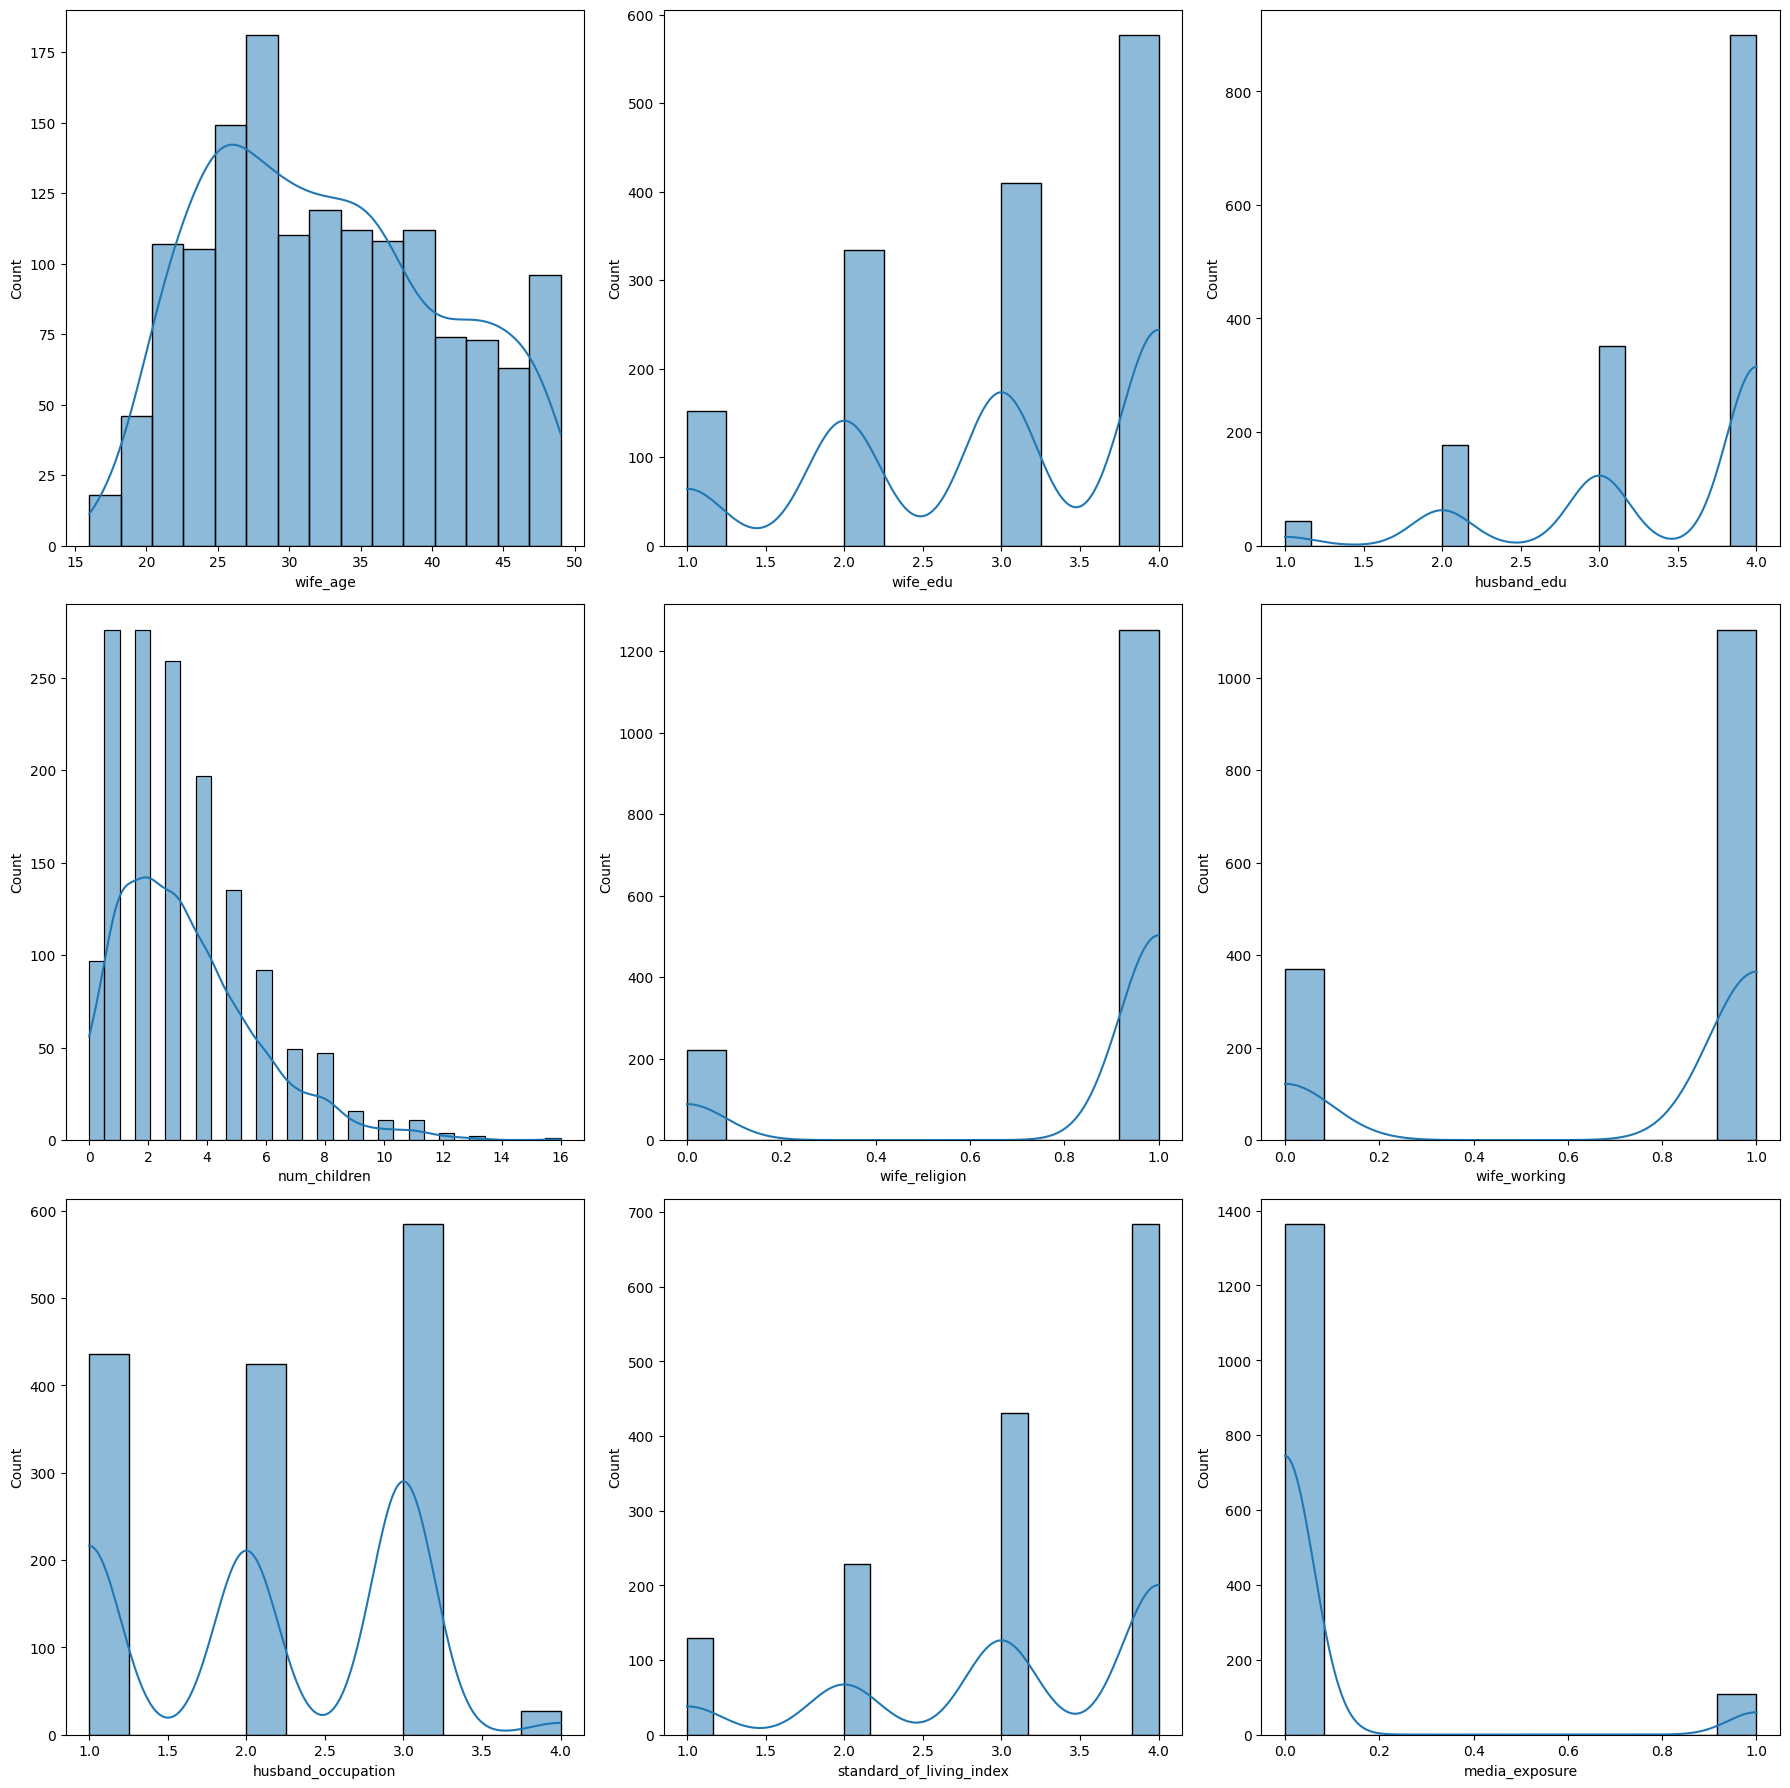

In [6]:
# 使用可视化分析每个变量的分布函数
plt.figure(figsize=(18, 18))
for i, col in enumerate(X_B.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X_B[col], kde=True)
plt.tight_layout()

array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]])

In [34]:
[i for i in y_B.iloc[:, 0].value_counts().index]

[1, 3, 2]

Text(0.5, 1.0, 'Pie chart')

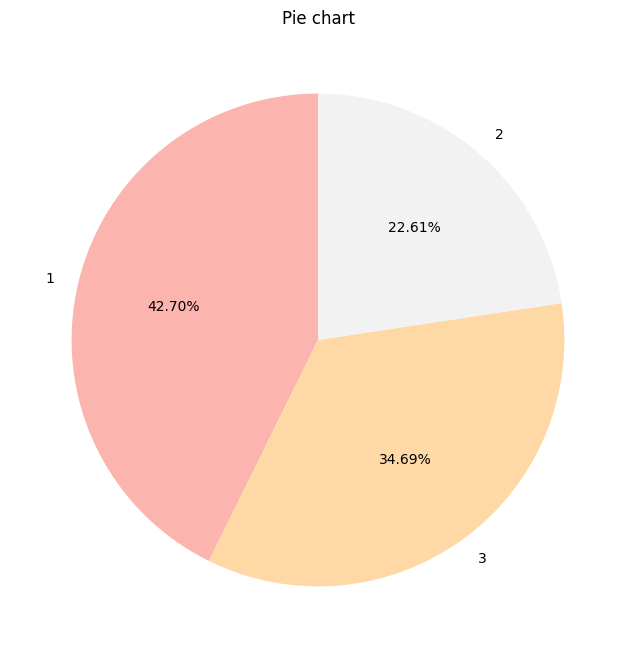

In [40]:
# 对于target value的不同类别进行统计
B_colors = [cmap(i) for i in np.linspace(0, 1, len(y_B.value_counts()))]
plt.figure(figsize=(8, 8))
plt.pie(y_B.value_counts(), autopct='%.2f%%', startangle=90, labels=[i for i in y_B.iloc[:, 0].value_counts().index], colors=B_colors)
plt.title('Pie chart')


In [45]:
B_ovo, B_ovr = simple_nn_train(MLPClassifier(solver='adam', warm_start=True, early_stopping=True), X=X_B.iloc[:, :], y=y_B.iloc[:, 0], iter=100)

Iteration 10/ 100: Using Stragety ovo f1_score=0.558; roc_auc=0.745
Iteration 20/ 100: Using Stragety ovo f1_score=0.555; roc_auc=0.751
Iteration 30/ 100: Using Stragety ovo f1_score=0.573; roc_auc=0.756
Iteration 40/ 100: Using Stragety ovo f1_score=0.576; roc_auc=0.762
Iteration 50/ 100: Using Stragety ovo f1_score=0.575; roc_auc=0.764
Iteration 60/ 100: Using Stragety ovo f1_score=0.574; roc_auc=0.768
Iteration 70/ 100: Using Stragety ovo f1_score=0.589; roc_auc=0.771
Iteration 80/ 100: Using Stragety ovo f1_score=0.582; roc_auc=0.774
Iteration 90/ 100: Using Stragety ovo f1_score=0.578; roc_auc=0.776
Iteration 100/ 100: Using Stragety ovo f1_score=0.583; roc_auc=0.777
Final Summary: Iterations 100, Stragety ovo, f1_score=0.583, roc_auc=0.777
Iteration 10/ 100: Using Stragety ovr f1_score=0.593; roc_auc=0.784
Iteration 20/ 100: Using Stragety ovr f1_score=0.582; roc_auc=0.783
Iteration 30/ 100: Using Stragety ovr f1_score=0.591; roc_auc=0.790
Iteration 40/ 100: Using Stragety ovr f1